# Setup

In [33]:
# !pip install transformers accelerate opencv-python torchlibrosa pydub ffmpeg-python vit-pytorch

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import cv2
from scipy.signal import resample
import wave
from sklearn.model_selection import train_test_split
import ffmpeg
# import librosa
from pydub import AudioSegment
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

import variables as var

In [36]:
# var.TO_PATH = "/content/drive/MyDrive/Thesis/PREP/sub_data"

In [37]:
# prep_df = pd.read_csv("/content/drive/MyDrive/Thesis/PREP/prepped_df.csv")
prep_df = pd.read_csv("data/SnapUGC/prepped_df.csv")
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifest...,NaN,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,NaN,NaN,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,NaN,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,NaN,skullskullskullskullHAHAHA,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 Years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,Finally it’s pumpkin season psl pumpkinspice...,It’s PSL season,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924


In [38]:
prep_df['Title'] = prep_df['Title'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
prep_df['Title'] = prep_df['Title'].str.replace(r'\s+', ' ', regex=True)
prep_df['Title'] = prep_df['Title'].str.strip().str.lower()

# replace nan with empty string
prep_df['Title'] = prep_df['Title'].fillna('')

In [39]:
downloaded_videos = os.listdir(var.DOWNLOAD_PATH + "/train")
downloaded_videos += os.listdir(var.DOWNLOAD_PATH + "/test")
downloaded_videos = [s.removesuffix(".mp4") for s in downloaded_videos]

prep_df = prep_df[prep_df["Id"].isin(downloaded_videos)]
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifestyle...,NaN,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,,NaN,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,,skullskullskullskullHAHAHA,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,finally its pumpkin season psl pumpkinspice pu...,It’s PSL season,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924


In [40]:
# def find_matching_ids(directory):
#     npz_ids = set()
#     wav_ids = set()

#     for file in os.listdir(directory):
#         if file.endswith(".npz"):
#             npz_ids.add(file[:-4])  # Remove .npz
#         elif file.endswith(".wav"):
#             wav_ids.add(file[:-4])  # Remove .wav

#     common_ids = npz_ids & wav_ids  # Find IDs present in both sets
#     return sorted(common_ids)

# existed_ids_train = find_matching_ids(var.TO_PATH + "/train")
# existed_ids_test = find_matching_ids(var.TO_PATH + "/test")

# prep_df = prep_df[prep_df["Id"].isin(existed_ids_train) | prep_df["Id"].isin(existed_ids_test)]
# prep_df.reset_index(drop=True, inplace=True)
# len(prep_df)

In [41]:
prep_df.sample(10)

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP
41579,31bda2032a3871ec8a6968a7fab4ad90,59.993267,110782,117399,,NaN,train,0.867015,0.895492
3103,658ad5931061921f80b60ef9fdee1dc3,25.100000,11993,4823,,NaN,train,0.093861,0.036789
30137,f5de7aaa9a8cc19697a2672287357dec,22.033333,69526,87023,cannonball rolling on the floor laughingbombsw...,NaN,train,0.544133,0.663791
48790,97c1f9d0c7572c0ab9df9094a6216be1,42.600000,123134,127915,she has a lot of time on her hands collegelife...,unemployed roommate @americanhigh2.0,train,0.963686,0.975706
57664,2fe21a9b5d91b6d3d3fa5e75389116da,39.483333,117319,128845,follow us to get smarter brain episode 148 tri...,NaN,test,0.918176,0.982799
28878,70899a759a982e30ab9a3e9d4bc89e12,18.166667,21950,81753,virgoseason virgovibes zodiacsigns zodiacs zod...,NaN,train,0.171788,0.623593
21136,09419f5a3155bf04e3e93cbb8645d662,17.133333,59974,50286,darnell,NaN,train,0.469376,0.383570
15647,8d06562e1ddf8c26a89dd496ef1b9b74,12.373938,28506,31868,,NaN,train,0.223097,0.243082
16595,990821d480a2ecc488d317023ebb4d58,29.366667,32678,34550,follow us to get smarter brain episode 167 tri...,NaN,train,0.255748,0.263539
20520,bfff61fa61bfe133a717f7746131811c,59.900000,10105,48024,spotlightoftheday foodspotlight musttry funnys...,Trader Joe’s pumpkin / fall items!! All things...,train,0.079085,0.366316


# Check distribution

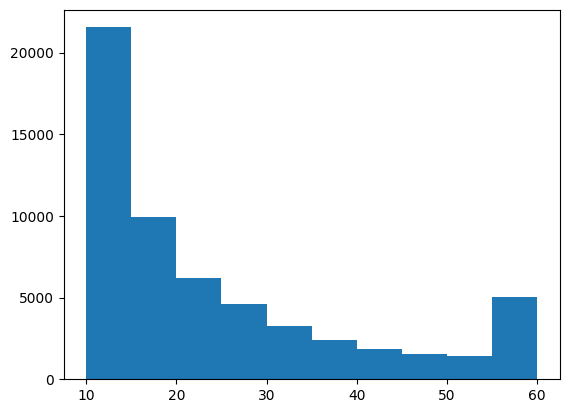

In [42]:
plt.hist(prep_df['Video_len'])
plt.show()

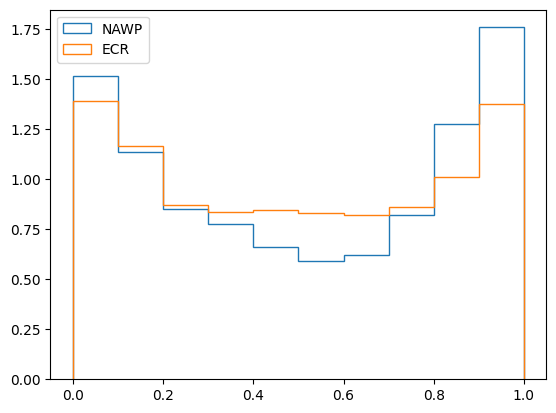

In [43]:
plt.hist(prep_df['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

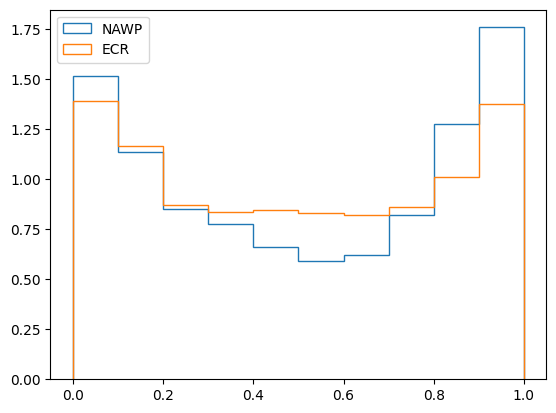

In [44]:
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

In [45]:
prep_df = prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]

In [46]:
prep_df['NAWP'].min(), prep_df['NAWP'].max(), prep_df['ECR'].min(), prep_df['ECR'].max()

(np.float64(0.0),
 np.float64(0.9999771167048056),
 np.float64(0.0),
 np.float64(1.0))

# Load data

In [47]:
sample_video = prep_df.sample(1).iloc[0]
sample_video

Id                                cc9542c172e7a4a7d63b230095cab4a3
Video_len                                                59.633333
order of ECR                                                 45246
order of NAWP                                                38488
Title            einmal und nie wieder wrdet ihr da hin gehen f...
Description                                                    NaN
Set                                                          train
ECR                                                        0.35411
NAWP                                                      0.293577
Name: 17531, dtype: object

In [48]:
def load_video_audio(video_path, 
                    target_height=var.TARGET_FRAME_SIZE[0], target_width=var.TARGET_FRAME_SIZE[1], target_fps=var.VIDEO_FPS, 
                    target_sample_rate=var.AUDIO_FPS,
                    start=0, end=None):
    """
    Extracts video frames and audio from a video file between start and end seconds, with resizing and downsampling.
    """
    # ---- Extract Video Frames with Fixed FPS ----
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps

    if end is None or end > duration:
        end = duration

    start_frame = int(start * original_fps)
    end_frame = int(end * original_fps)
    frame_interval = original_fps / target_fps if target_fps is not None else 1

    frames = []
    frame_idx = 0

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened():
        current_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if current_pos >= end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % round(frame_interval) == 0:
            h, w, _ = frame.shape

            # Resize with padding
            scale = min(target_width / w, target_height / h)
            new_w, new_h = int(w * scale), int(h * scale)
            resized_frame = cv2.resize(frame, (new_w, new_h))
            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            padded_frame = np.zeros((target_height, target_width, 3), dtype=np.uint8)
            pad_top = (target_height - new_h) // 2
            pad_left = (target_width - new_w) // 2
            padded_frame[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_frame

            frames.append(padded_frame)

        frame_idx += 1

    cap.release()
    video_array = np.array(frames, dtype=np.uint8)

    # ---- Extract and Downsample Audio (Trimmed) ----
    ffmpeg_args = {
        'format': 'wav',
        'ar': target_sample_rate,
        'ac': 1
    }

    input_args = {}
    if start != 0 and end is not None:
        input_args['ss'] = start
        input_args['to'] = end

    out, _ = (
        ffmpeg
        .input(video_path, **input_args)
        .output("pipe:", **ffmpeg_args)
        .run(capture_stdout=True, capture_stderr=True)
    )

    audio = AudioSegment.from_file(io.BytesIO(out), format="wav")
    samples = np.array(audio.get_array_of_samples(), dtype=np.int16)

    return video_array, samples



print(f"Sample ID: {sample_video['Id']}")

video_loaded, audio_loaded = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample_video['Set'], sample_video['Id'] + ".mp4"),
                                              start=0, end=None)
print(f"Loaded Video Shape: {video_loaded.shape}")  # (num_frames, height, width, 3)
print(f"Loaded Audio Shape: {audio_loaded.shape}")

Sample ID: cc9542c172e7a4a7d63b230095cab4a3
Loaded Video Shape: (299, 224, 128, 3)
Loaded Audio Shape: (950346,)


In [49]:
# plt.imshow(video_loaded[0])
# plt.show()

# from IPython.display import Audio
# Audio(audio_loaded, rate=16000)

# Create dataset

Numeric to label

In [50]:
THRESHOLD = 0.5 # [0.3, 0.7]

def get_label(x):
    if type(THRESHOLD) == list:
        if x < THRESHOLD[0]:
            return 0
        elif x > THRESHOLD[1]:
            return 2
        else:
            return 1
    else:
        if x <= THRESHOLD:
            return 0
        else:
            return 1

prep_df['Target'] = prep_df['NAWP'].apply(get_label) # small ECR is positive
prep_df

,Id,Video_len,order of ECR,order of NAWP,Title,Description,Set,ECR,NAWP,Target
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,zanzibarisland zanzibarbeach zanzibarlifestyle...,NaN,train,0.000000,0.000000,0
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,,NaN,train,0.000000,0.000000,0
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,,استخراج السائل هذا للبشره smiling face with he...,train,0.000000,0.000000,0
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,,skullskullskullskullHAHAHA,train,0.000000,0.000000,0
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,spotlightviral spotlight lmao viral trending,NaN,train,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,sportscommentator voiceover,NaN,test,0.269961,0.999466,1
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,12 years or snapmemories in 12 seconds,In 12 seconds | 12 years of Snap Memories,test,0.371187,0.999596,1
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,finally its pumpkin season psl pumpkinspice pu...,It’s PSL season,test,0.275392,0.999893,1
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,thick thickgirls curves thickthighs curvey,NaN,test,0.012459,0.999924,1


In [51]:
def to_num_frames(video_array, target_frame):
    num_frames = video_array.shape[0]

    if num_frames == target_frame:
        return video_array
    elif num_frames < target_frame:
        # Pad with zeros if fewer frames than target
        padding = np.zeros((target_frame - num_frames, video_array.shape[1], video_array.shape[2], video_array.shape[3]), dtype=np.uint8)
        return np.concatenate((video_array, padding), axis=0)

    indices = np.linspace(0, num_frames - 1, target_frame).astype(int)
    return video_array[indices]

In [52]:
def pad_audio(audio_array, target_length):
    if len(audio_array) >= target_length:
        return audio_array[:target_length]
    else:
        padding = np.zeros(target_length - len(audio_array), dtype=np.int16)
        return np.concatenate((audio_array, padding), axis=0)

In [2]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import wave
import os
from transformers import BertModel, BertTokenizer
import torchaudio.transforms as T

config = {
    'frame_size': 224,
    'video_fps': None,
    'num_frames': 32,
    'audio_hz': 16000,
    'max_seconds': 60
}

# title_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

mel_transform = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            hop_length=160,
            n_mels=64
        )
db_transform = T.AmplitudeToDB()

class VideoAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        sample_id = sample["Id"]

        video_array, audio_array = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample["Set"], sample_id + ".mp4"),
                                                    target_height=config['frame_size'], # var.TARGET_FRAME_SIZE[0],
                                                    target_width=config['frame_size'],# var.TARGET_FRAME_SIZE[1],
                                                    target_fps=config['video_fps'],
                                                    target_sample_rate=config['audio_hz'],
                                                    start=0, end=config['max_seconds'])

        # slow_array = to_num_frames(video_array, target_frame=config['num_frames'][0])
        # slow_tensor = torch.tensor(slow_array, dtype=torch.float32)
        
        fast_array = to_num_frames(video_array, target_frame=config['num_frames'])
        fast_tensor = torch.tensor(fast_array, dtype=torch.float32)
        
        audio_array = pad_audio(audio_array, target_length=config['audio_hz'] * config['max_seconds'])
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)

        # Convert waveform to log-mel spectrogram
        # mel_spec = mel_transform(audio_tensor)  # [B, 64, T']
        # log_mel = db_transform(mel_spec)  # [B, 64, T']
        
        # # VGGish expects [B, 1, 96, 64]
        # if log_mel.size(-1) < 96:
        #     pad = 96 - log_mel.size(-1)
        #     log_mel = nn.functional.pad(log_mel, (0, pad))
        # log_mel = log_mel[:, :, :96]  # Crop/pad to [B, 64, 96]
        # log_mel = log_mel.transpose(1, 2).unsqueeze(1)  # [B, 1, 96, 64]

        # log_mel = log_mel.squeeze(0)  # Remove batch dimension


        # Title
        # title_inputs = title_tokenizer(
        #     sample["Title"],
        #     padding="max_length",
        #     truncation=True,
        #     max_length=32,
        #     return_tensors="pt"
        # )
        
        # Label
        label = sample['Target']
        label_tensor = torch.tensor(label,  dtype=torch.long) # dtype=torch.long)

    
        return {
            "id": sample_id,
            # "slow": slow_tensor,
            "fast": fast_tensor,
            "audio": audio_tensor,
            # "title_input_ids": title_inputs['input_ids'].squeeze(0),
            # "title_attention_mask": title_inputs['attention_mask'].squeeze(0),
            "label": label_tensor
        }

# Split data

In [54]:
# test with small subset
prep_df = prep_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [55]:
train_df = prep_df[prep_df["Set"] == "train"]

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

test_df = prep_df[prep_df["Set"] == "test"]

len(train_df), len(val_df), len(test_df)

(4065, 1017, 702)

In [56]:
BATCH_SIZE = 2

In [57]:
trainset = VideoAudioDataset(train_df)
valset = VideoAudioDataset(val_df)
testset = VideoAudioDataset(test_df)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [58]:
sample_batch = next(iter(train_loader))
sample_batch['fast'].shape, sample_batch['audio'].shape, sample_batch['label'].shape

(torch.Size([2, 32, 224, 224, 3]), torch.Size([2, 960000]), torch.Size([2]))

# Define model

## Video encoder

In [59]:
import torch
import torch.nn as nn
from vit_pytorch.vivit import ViT

class VideoEncoder3DViT(nn.Module):
    def __init__(self, out_dim=512, dropout=0.3):
        super().__init__()
        self.vivit = ViT(
            image_size = 224,          # image size
            frames = config['num_frames'],               # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = out_dim,
            dim = 1024,
            spatial_depth = 6,         # depth of the spatial transformer
            temporal_depth = 6,        # depth of the temporal transformer
            heads = 8,
            mlp_dim = 2048,
            dropout = dropout,
            variant = 'factorized_encoder', # or 'factorized_self_attention'
        )
        
        self.lnorm = nn.LayerNorm(out_dim)

    def forward(self, x):  # (B, T, H, W, 3)
        x = x / 255.0  # Normalize to [0, 1]
        x = x.permute(0, 4, 1, 2, 3)  # (B, C, T, H, W)
        x = self.vivit(x)  # (B, dim)
        x = self.lnorm(x)  # (B, dim)
        return x

class AudioEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super(AudioEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(256, out_dim)
        self.lnorm = nn.LayerNorm(out_dim)


    def forward(self, x):  # x: (B, N)
        x = torch.clamp(x / 32768.0, -1.0, 1.0)  # Normalize to [-1, 1] with clamping
        x = x.unsqueeze(1)  # (B, 1, N)
        x = self.cnn(x)  # (B, 128, 1)
        x = x.view(x.size(0), -1)  # (B, 128)
        x = self.fc(x)  # (B, out_dim)
        x = self.lnorm(x)
        return x

class AudioVisualModel(nn.Module):
    def __init__(self, fusion_dim=1024, num_classes=2):
        super(AudioVisualModel, self).__init__()
        self.video_encoder = VideoEncoder3DViT(out_dim=512)
        self.audio_encoder = AudioEncoder(out_dim=512)
        self.fusion = nn.Sequential(
            nn.Linear(1024, fusion_dim),
            nn.ReLU(),
            nn.LayerNorm(fusion_dim)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, video_frames, audio_waveform):
        # video_frames: (B, T, H, W, 3)
        # audio_waveform: (B, N)
        video_feat = self.video_encoder(video_frames)  # (B, 512)
        audio_feat = self.audio_encoder(audio_waveform)  # (B, 512)
        fused = torch.cat([video_feat, audio_feat], dim=-1)  # (B, 1024)
        fused = self.fusion(fused)  # (B, 1024)
        
        return self.classifier(fused)  # (B, num_classes)

In [60]:
device = 'cpu'
model = AudioVisualModel().to(device)
model(sample_batch["fast"].to(device),
      sample_batch["audio"].to(device)).shape

torch.Size([2, 2])

# Train step

In [31]:
def training_step(batch, model: AudioVisualModel, optimizer):
    model.train()
    
    label = batch["label"].cuda()       # (B, 2)

    # Forward pass
    pred = model(batch['fast'].cuda(), 
                 batch['audio'].cuda())
        
    cls_loss = F.cross_entropy(pred, label)

    # Backpropagation
    optimizer.zero_grad()
    cls_loss.backward()
    optimizer.step()

    return {
        "loss": cls_loss.item(),
        "pred": pred.detach(),
        "label": label.detach()
    }

@torch.no_grad()
def validation_step(batch, model):
    model.eval()
    label = batch["label"].cuda()       # (B, 2)

    # Forward pass
    pred = model(batch['fast'].cuda(), 
                 batch['audio'].cuda())
        
    cls_loss = F.cross_entropy(pred, label)

    prob = torch.softmax(pred, dim=1)
    
    return {
        "loss": cls_loss.item(),
        "pred": pred.detach().cpu(),
        "prob": prob.detach().cpu(),
        "label": label.detach().cpu()
    }

# Training

In [32]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

# === Config ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AudioVisualModel(num_classes=2).to(device)
device

TypeError: AudioVisualModel.__init__() got an unexpected keyword argument 'num_classes'

In [ ]:
checkpoints_path = "clf_checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)
# model.load_state_dict(torch.load(f"small_checkpoints/snap_stage_1_best.pth"))

In [ ]:
cfg = {
    'num_epochs': 5,
    'lr': 1e-4,
}

In [ ]:
# === Training Loop ===
start_from_epoch = 0

optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])

# First train only the AV model
best_val_acc = 0.0  # Track best validation accuracy

for epoch in range(cfg['num_epochs']):
    if epoch < start_from_epoch:    
        continue
    # TRAINING
    model.train()
    total_loss = 0
    cc = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in pbar:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        metrics = training_step(batch, model, optimizer)
        
        # Accumulate loss
        total_loss += metrics["loss"]
        
        # Calculate accuracy
        pred_classes = torch.argmax(metrics["pred"], dim=1)
        correct += (pred_classes == metrics["label"]).sum().item()
        total += metrics["label"].size(0)
        train_acc = 100 * correct / total if total > 0 else 0
        
        # Logging
        if cc % 100 == 0:
            normalized_pred = torch.softmax(metrics["pred"], dim=-1)
            pbar.write(f"\tProb: {normalized_pred}")
            pbar.write(f"\tPred: {pred_classes}, Label: {metrics['label']}")
            pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
            # pbar.write(f"\tPred: {metrics["pred"]}, Label: {metrics['label']}")
            # pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
        cc += 1
        
        # Update progress bar
        pbar.set_postfix({
            "Avg Loss": f"{total_loss / cc:.4f}",
            "Acc": f"{train_acc:.2f}%"
        })
    
    # Final training metrics for this epoch
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total if total > 0 else 0
    
    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_pbar = tqdm(val_loader, desc=f"Validation")
    
    with torch.no_grad():
        for batch in val_pbar:
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            metrics = validation_step(batch, model)
            
            # Accumulate loss
            val_loss += metrics["loss"]
            
            # Calculate accuracy
            val_pred_classes = torch.argmax(metrics["pred"], dim=1)
            val_correct += (val_pred_classes == metrics["label"]).sum().item()
            val_total += metrics["label"].size(0)
            val_acc = 100 * val_correct / val_total if val_total > 0 else 0
            
            # Update progress bar
            val_pbar.set_postfix({
                "Avg Loss": f"{val_loss / (val_pbar.n + 1):.4f}",
                "Acc": f"{val_acc:.2f}%"
            })
    
    # Final validation metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total if val_total > 0 else 0
    
    # Save model if it's the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_1_best.pth")
        print(f"New best model saved with accuracy: {val_acc:.2f}%")
        
    # Always save epoch checkpoint
    torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_1_epoch_{epoch + 1}.pth")

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Evaluate

In [ ]:
raise NotImplementedError

In [ ]:
# Test step
all_results = []

test_loss = 0
test_cc = 0
test_pbar = tqdm(test_loader, desc=f"Testing")
for batch in test_pbar:
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    metrics = validation_step(batch, model, cfg)
    test_loss += metrics["loss"]
    all_results.append(metrics)
    test_cc += 1
    test_pbar.set_postfix({
        "Avg Loss": f"{test_loss / test_cc:.4f}",
    })

In [ ]:
all_results

In [ ]:
loss_list = [entry['loss'] for entry in all_results]

In [ ]:
plt.plot(loss_list)

In [ ]:
all_probs = []
all_labels = []

for entry in all_results:
    all_probs.extend([row for row in entry['prob']])
    all_labels.extend([row for row in entry['label']])

len(all_probs), len(all_labels)

In [ ]:
plt.hist([el[0] for el in all_probs], range=[0,1], bins=50, alpha=0.5, label='ECR')

In [ ]:
plt.hist([el[0] for el in all_labels], range=[0,1], bins=50, alpha=0.5, label='ECR')

In [ ]:
@torch.no_grad()
def inference_step_with_interpretability(batch, model, cfg, concept_names=None, top_k=5):
    model.eval()
    video = batch["video"].cuda()
    audio = batch["audio"].cuda()

    # Forward pass
    img_feat, cls_feat = model(video, audio, cfg)  # (B, D), (num_classes, D)
    sim = img_feat @ cls_feat.T                    # (B, num_classes)
    pred = 100 * sim                               # logits
    prob = torch.sigmoid(pred)                    # (B, num_classes)

    results = []

    # For each sample in batch
    for i in range(video.size(0)):
        sample_result = {
            "prob": prob[i].cpu(),
            "logits": pred[i].cpu(),
            "concept_scores_per_class": {}
        }

        # Get normalized concept features
        text_feat = model.text_features / model.text_features.norm(dim=-1, keepdim=True)  # (num_concepts, D)
        weight_mat = model.get_weight_mat(cfg)  # (num_classes, num_concepts)

        # For each class, compute weighted contribution of each concept
        for cls_idx in range(weight_mat.shape[0]):
            weights = weight_mat[cls_idx]  # (num_concepts,)
            concept_contrib = weights @ text_feat  # (D,)
            concept_score = F.cosine_similarity(img_feat[i], concept_contrib, dim=0).item()

            # Top contributing concepts
            topk_weights, topk_idx = torch.topk(weights, k=top_k)
            concept_info = []
            for j in range(top_k):
                concept_name = concept_names[topk_idx[j].item()] if concept_names else f"concept_{topk_idx[j].item()}"
                concept_info.append({
                    "concept": concept_name,
                    "weight": topk_weights[j].item()
                })

            sample_result["concept_scores_per_class"][f"class_{cls_idx}"] = {
                "similarity": concept_score,
                "top_concepts": concept_info
            }

        results.append(sample_result)

    return results


# Infer